# 1. Exploring data

## 1.1. Loading packages

In [1]:
pip install factor_analyzer

     |████████████████████████████████| 41 kB 466 kB/s 
  Created wheel for factor-analyzer: filename=factor_analyzer-0.4.0-py3-none-any.whl size=41455 sha256=fd6993dafa4b9a451cd5f8591be6e4c4588db0301737f952e2e1ed70e07c7594
  Stored in directory: /root/.cache/pip/wheels/ac/00/37/1f0e8a5039f9e9f207c4405bbce0796f07701eb377bfc6cc76
Successfully built factor-analyzer


In [2]:
import numpy as np
import pandas as pd 

# plot graph
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

# date and time 
from datetime import date
from datetime import datetime

# preprocessing
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

# supervised learning
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
import graphviz as gp
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

# unsupervised learning
from sklearn import decomposition as dcp
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from IPython.display import SVG, display
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo


# ignore warning
import warnings
warnings.filterwarnings("ignore")

## 1.2. Import data

In [3]:
from google.colab import files
uploaded = files.upload()

Saving customer-personality.csv to customer-personality.csv


In [4]:
data = pd.read_csv('customer-personality.csv')
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5


## 1.3. Drop missing and duplicate rows

In [5]:
# check duplicate rows
data.duplicated().any()

False

In [6]:
# check duplicate ID
data['ID'].nunique()

2240

In [7]:
# check for missing value
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
miss_data = pd.DataFrame({'Data Missing Ratio' :data_na})
miss_data.head()

,Data Missing Ratio
Income,1.071429


There are only 24 missing values in `Income` variables, which accounts only 1% of the dataset. Therefore we can do listwise deletion in this case

In [8]:
# drop missing rows
df = data.dropna().reset_index(drop=True)

## 1.4. Creating new variables

In [9]:
# create age variables 
df['Age'] = pd.Timestamp('now').year - df['Year_Birth']

# create years customers show how long has the customers been with us 
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
df['Years_customer'] = (pd.Timestamp('now').year) - (pd.to_datetime(df['Dt_Customer']).dt.year)

In [10]:
# combine total expense
df['Total_Expenses'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

# combine total number of purchase 
df['Total_Purchases'] = df['NumDealsPurchases'] + df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']  

# combine total number of children
df['Total_Childs'] = df['Kidhome'] + df['Teenhome']

# total member in family
df['Family_members'] = np.where(((df["Marital_Status"] == 'Single') ), 1, 2) + df["Total_Childs"]

In [11]:
# group marital status
df['Marital_Status_group'] = np.where(((df["Marital_Status"] == 'Single') |
                                   (df["Marital_Status"] == 'Divorced') |
                                   (df["Marital_Status"] == 'Widow') |
                                   (df["Marital_Status"] == 'Alone') |
                                   (df["Marital_Status"] == 'Absurd') |
                                   (df["Marital_Status"] == 'YOLO')  ), 'Single', 'Couples')

# group education
df['Education_1'] = np.where(((df["Education"] == 'Graduation') | (df["Education"] == '2n Cycle')  ), 
                             'Undergraduate', 'Higher education')

In [12]:
# drop redundancy variables
df = df.drop(['Dt_Customer','Year_Birth','ID','Marital_Status','Education'], axis = 1)

# rename columns
df.rename(columns={'Marital_Status_group': 'Marital_Status', 'Education_1': 'Education'}, inplace=True)

## 1.5. Remove outlier

In [13]:
df.describe()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Years_customer,Total_Expenses,Total_Purchases,Total_Childs,Family_members
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,4.085289,2.671029,5.800993,5.319043,53.179603,8.971570,607.075361,14.880866,0.947202,2.734657
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,2.740951,2.926734,3.250785,2.425359,11.985554,0.685618,602.900476,7.670957,0.749062,0.875546
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,26.000000,8.000000,5.000000,0.000000,0.000000,1.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,2.000000,0.000000,3.000000,3.000000,45.000000,9.000000,69.000000,8.000000,0.000000,2.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,4.000000,2.000000,5.000000,6.000000,52.000000,9.000000,396.500000,15.000000,1.000000,3.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,6.000000,4.000000,8.000000,7.000000,63.000000,9.000000,1048.000000,21.000000,1.000000,3.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,27.000000,28.000000,13.000000,20.000000,129.000000,10.000000,2525.000000,44.000000,3.000000,5.000000


In [14]:
# Income outliers
## by using Z_score
Z = stats.zscore(df['Income'], nan_policy='omit') #compute z-score variable
outliers_income_index = np.where((Z>3) | (Z<-3))
## drop outliers by index
df = df.drop(df.index[outliers_income_index]).reset_index(drop=True)

In [15]:
# Delete rows with age > 100, which seems no meaning
df = df.loc[df['Age']<100,:]

## 1.6. Visualization

In [16]:
# plot marital status and education
df_sb = df.groupby(['Education','Marital_Status','Total_Childs']).size().reset_index(name='counts')
fig_sb = px.sunburst(df_sb, path=['Education', 'Marital_Status','Total_Childs'], 
                  values='counts',title='Sunburst chart')
fig_sb.show()

In [17]:
# plot of income
fig_inc = px.histogram(df, x ='Income', marginal="box",title="Histplot of Income")
fig_inc.show()

In [18]:
# plot of age
fig_age = px.histogram(df, x ='Age', marginal="box",title="Histplot of Age")
fig_age.show()

In [19]:
# boxplot of age
fig_rec = px.histogram(df, x ='Recency', marginal="box",title="Histplot of Recency")
fig_rec.show()

In [20]:
# plot products
fig_amt = go.Figure()
fig_amt.add_trace(go.Box(y=df['MntWines'], name='Wines', marker_color = 'blue'))
fig_amt.add_trace(go.Box(y=df['MntFruits'], name='Fruits', marker_color = '#FF4136'))
fig_amt.add_trace(go.Box(y=df['MntMeatProducts'], name='Meat', marker_color = 'green'))
fig_amt.add_trace(go.Box(y=df['MntFishProducts'], name='Fish', marker_color = 'purple'))
fig_amt.add_trace(go.Box(y=df['MntSweetProducts'], name='Sweet', marker_color = 'orange'))
fig_amt.add_trace(go.Box(y=df['MntGoldProds'], name='Gold', marker_color = 'lightblue'))

fig_amt.update_layout(title_text="Box Plot Product amount")
fig_amt.update_yaxes(title = "Counts")
fig_amt.show()

In [21]:
df_kid = df[['Kidhome','Teenhome']].melt(var_name="Children")
df_kid = df_kid.groupby(['Children','value']).size().reset_index(name='counts')
df_kid['Number of children'] = df_kid['value'].apply(str)

fig_kid = px.bar(df_kid, x="Number of children", y="counts", color="Children", title="Total number of children")
fig_kid.show()

In [22]:
# plot purchase
fig_puc = go.Figure()
fig_puc.add_trace(go.Box(y=df['NumDealsPurchases'], name='Deals', marker_color = 'orange'))
fig_puc.add_trace(go.Box(y=df['NumWebPurchases'], name='Web', marker_color = 'lightblue'))
fig_puc.add_trace(go.Box(y=df['NumCatalogPurchases'], name='Catalog', marker_color = 'green'))
fig_puc.add_trace(go.Box(y=df['NumStorePurchases'], name='Store', marker_color = 'purple'))

fig_puc.update_layout(title_text="Box Plot Purchase amount")
fig_puc.update_yaxes(title = "Counts")
fig_puc.show()

In [23]:
# boxplot of NumWebVisitsMonth
fig_rec = px.histogram(df, x ='NumWebVisitsMonth', marginal="box",title="Histplot of Recency")
fig_rec.show()

## 1.7. Correlation

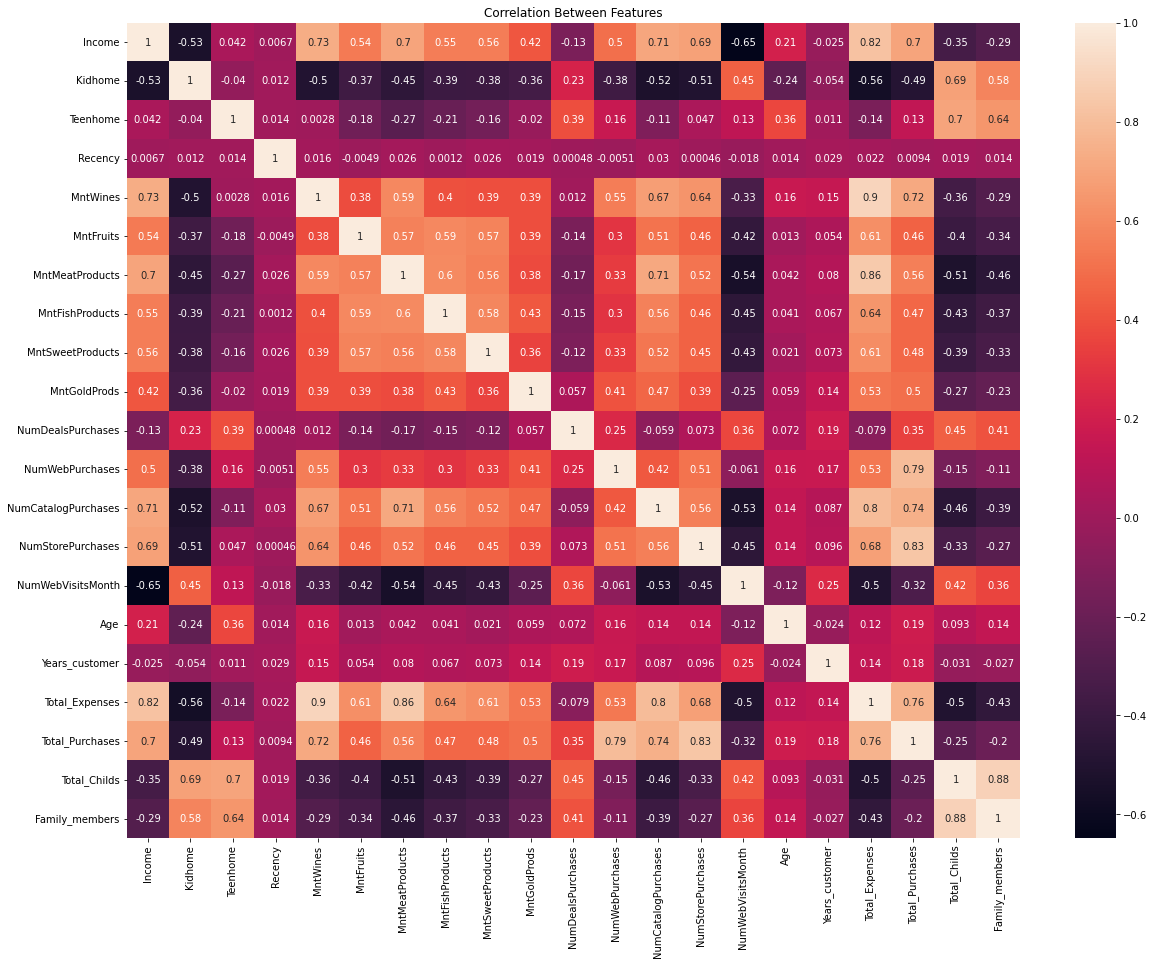

In [24]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(), annot=True)
plt.title("Correlation Between Features");

We have some variables with a high correlation in our dataset, which correlation between a pair of variables is greater than 0.5-0.6. We will consider about this later.

## 1.8. Encode categorical values

In [25]:
df_encode = df.copy()

# Encode categorical values: 
categoricals_cols = (df_encode.dtypes == 'object')
object_cols = list(categoricals_cols[categoricals_cols].index)

# Encode labels 
le = LabelEncoder()
for i in object_cols:
    df_encode[i]=df_encode[[i]].apply(le.fit_transform)

## 1.9. Normalized data

In [26]:
df1 = df_encode.copy()
# Scale with Standard scaler 
scaler = StandardScaler()
scaler.fit(df1)
df_scaled = pd.DataFrame(scaler.transform(df1),columns= df1.columns )

# 2. Dimension reduction

## 2.1. Supervised Learning
In the business perspective, companies would like to consider how much money do customers spend at there store. Therefore, we would choose `Total_Expenses` as out independent variables, and understand the relationship between others variables on total expense of customers.

As we stated before, there are some high correlation variables, hence, for supervised learning, we will drop some of them.

In [27]:
# Prepare variables that will be used in the models
df_supervised = df1.drop(list(df1.columns[range(4,15)]), axis = 1)
df_supervised = df_supervised.drop(['Kidhome','Teenhome', 'Family_members'], axis=1)
df_supervised.head()

,Income,Recency,Age,Years_customer,Total_Expenses,Total_Purchases,Total_Childs,Marital_Status,Education
0,58138.0,58,65,10,1617,25,0,1,1
1,46344.0,38,68,8,27,6,2,1,1
2,71613.0,26,57,9,776,21,0,0,1
3,26646.0,26,38,8,53,8,1,0,1
4,58293.0,94,41,8,422,19,1,0,0


### 2.1.1 Decision Tree vs Random forest

#### Decision tree

In [28]:
X = df_supervised.drop(['Total_Expenses'], axis=1)
Y = df_supervised['Total_Expenses']

In [29]:
#Split 60% training set, 20% test set, 20% validation set
testX,otherX,testY,otherY = train_test_split(X, Y, test_size=0.8,random_state=113)
trainX,validationX,trainY,validationY = train_test_split(otherX,otherY,test_size=0.25,random_state=113)

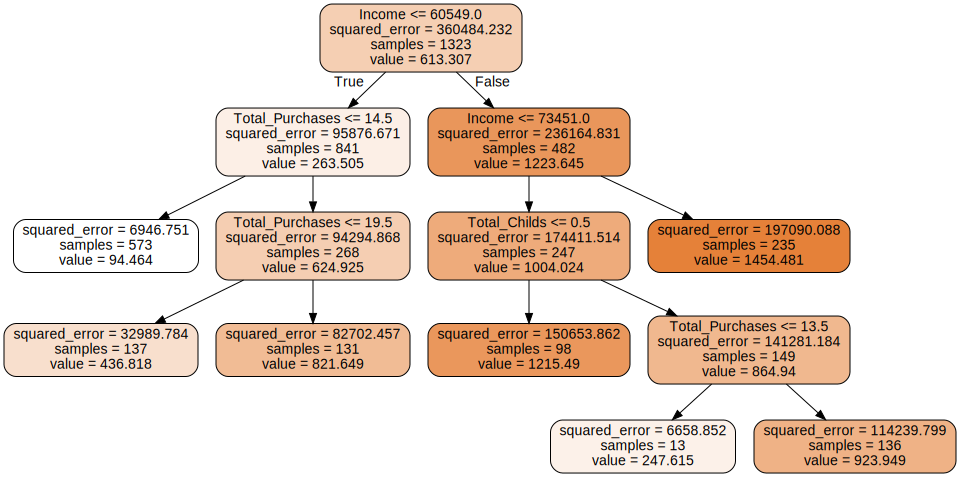

In [30]:
#Fit a decision tree with 7 leaf nodes
regressor_DT = DecisionTreeRegressor(max_leaf_nodes = 7)
regressor_DT.fit(trainX, trainY)
#Graph the decision tree
dot_data = export_graphviz(regressor_DT, feature_names = trainX.columns, filled = True, rounded = True, class_names=["Died","Survived"])
graph = gp.Source(dot_data)
graph

In [31]:
#Compute the accuracy on the validation data
y_pred = regressor_DT.predict(validationX)
mse = mean_squared_error(validationY,y_pred)
r2 = r2_score(validationY,y_pred)
print("The validation RMSE for the tree model with 7 leaf nodes is", round(mse**0.5,2))
print(round(r2*100,2), "% of variance is explained by the the tree model with 7 leaf nodes")

The validation RMSE for the tree model with 7 leaf nodes is 261.32
80.09 % of variance is explained by the the tree model with 7 leaf nodes


In [32]:
#Use the validation set to optimize how many leaves we should have in our tree
n_max_leaf_nodes = range(2,60)
train_array = []
validation_array = []
for n in n_max_leaf_nodes:

    regressor_DT = DecisionTreeRegressor(max_leaf_nodes = n)
    regressor_DT = regressor_DT.fit(trainX, trainY)
    
    y_train_pred = regressor_DT.predict(trainX)
    y_validation_pred = regressor_DT.predict(validationX)
    
    train_mse = mean_squared_error(trainY,y_train_pred)
    validation_mse = mean_squared_error(validationY,y_validation_pred)

    train_array.append([n,train_mse**0.5])
    validation_array.append([n,validation_mse**0.5])

In [33]:
#Plot both accuracy levels over the chosen number of nodes
## data to plot
array = pd.DataFrame(validation_array)
array.rename(columns={0: 'Number of leaves', 1: 'Validation set'}, inplace=True)
array['Training set'] = pd.DataFrame(train_array)[1]
array = array.melt(id_vars=['Number of leaves'],
    value_vars=['Validation set', 'Training set'],
    var_name='Set', value_name='RMSE')
## plot
fig_tr = px.line(array, x="Number of leaves", y="RMSE", color="Set", 
                 hover_data= array,markers=True,title='Accuracy levels over the chosen number of nodes')
fig_tr.show()

As we can see in the graph above, model fit with 20 leaves will produce nealy lowest RMSE. Therefore, we would choose 20 leaves to fit in our model.

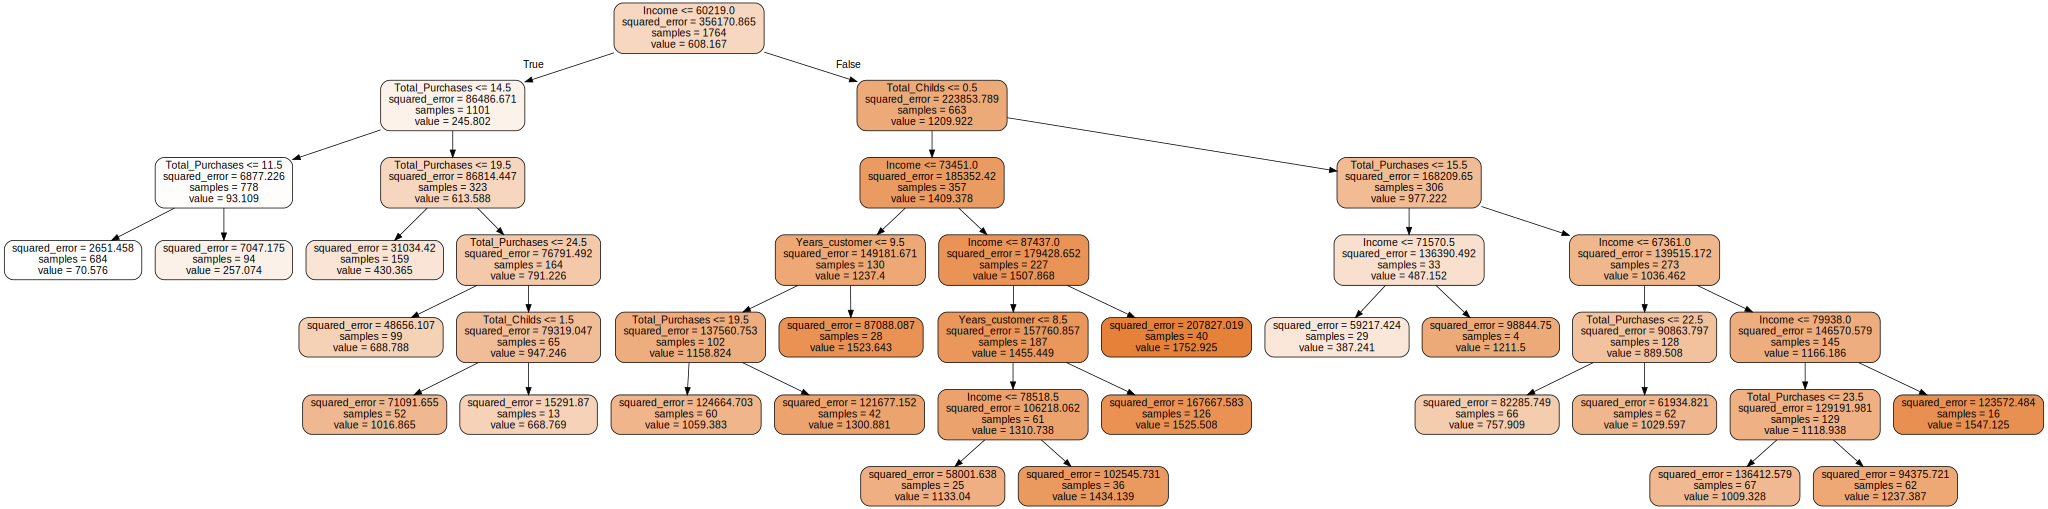

In [34]:
#The graph suggests number of leaves around 20. We now fit the model on a dataset consisting of both training and validation data
leaf = 20
regressor_DT = DecisionTreeRegressor(max_leaf_nodes = leaf)
regressor_DT.fit(otherX, otherY)
#Graph the decision tree
dot_data = export_graphviz(regressor_DT, feature_names = otherX.columns, filled = True, rounded = True, class_names=["Died","Survived"])
graph = gp.Source(dot_data)
graph

In [35]:
#Finally, we test the model on our testing set
y_pred = regressor_DT.predict(testX)
mse = mean_squared_error(testY,y_pred)
r2 = r2_score(testY,y_pred)
print(f"The test RMSE for the tree model with {leaf} leaf nodes is", round(mse**0.5,2))
print(round(r2*100,2), "% of variance is explained by the the tree model with 18 leaf nodes")

The test RMSE for the tree model with 20 leaf nodes is 252.78
83.38 % of variance is explained by the the tree model with 18 leaf nodes


#### Random forest

In [36]:
# fit random forest regressor
regressor_RF = RandomForestRegressor(max_leaf_nodes=leaf, max_features=3)
regressor_RF.fit(otherX, otherY)
#Predict on the testing data, and compute MSE
ypredict = regressor_RF.predict(testX)
MSE_RF = mean_squared_error(testY,ypredict)
r2_RF = r2_score(testY,ypredict)
print("The test RMSE for the random forest model is", round(MSE_RF**0.5,2))
print(round(r2_RF*100,2), "% of variance is explained by the the random forest model")

The test RMSE for the random forest model is 237.7
85.31 % of variance is explained by the the random forest model


Both test RMSE and percentage of explained variance are improves. Therefore we would choose random forest regressor for our supervised learning.

### 2.1.2. Features importance

In [84]:
# feature importance
## data to plot
forest_importances = pd.DataFrame({'Importance':regressor_RF.feature_importances_, 
                                   'Features':list(X.columns)}).sort_values('Importance',ascending=True)
## plotly
fig_imp = px.bar(forest_importances, x='Importance', y='Features',
             hover_data=forest_importances, color='Importance', 
             height=500, 
             title = 'Features Importance')
fig_imp.show()
fig_imp.write_html("1.Importance.html")

There 3 most importance features that we should consider, which are `Income`,`Total_purchase`, and `Total_childs`

## 2.2. Unsupervised learning

### 2.2.1. PCA vs Factor analysis

#### PCA

In [38]:
# number of variables
N = len(df_scaled.columns)
print("Number of variables is",N)

Number of variables is 23


Let's fit with 95% of variance to be explained 

In [39]:
# Set n_components for 95% of variance to be explained 
pca=dcp.PCA(n_components=0.95)
pca.fit(df_scaled)

PCA(n_components=0.95)

In [40]:
explained_variance_ratio_cumul_sum=np.cumsum(pca.explained_variance_ratio_) #compute the cumulative sum
explained_variance_ratio_cumul_sum

array([0.373101  , 0.50239657, 0.56875377, 0.62703005, 0.67320829,
       0.71700069, 0.75836441, 0.79434106, 0.8227663 , 0.85034441,
       0.87625752, 0.89938839, 0.91814383, 0.93658545, 0.95356093])

In [85]:
# plot of cummulative ẽplained variance ratio
fig1 = px.area(
    x=range(1, explained_variance_ratio_cumul_sum.shape[0] + 1),
    y=explained_variance_ratio_cumul_sum,
    labels={"x": "# Components", "y": "Explained Variance"}
)
fig1.add_trace(go.Scatter(x=np.arange(1,explained_variance_ratio_cumul_sum.shape[0]+1), 
                          y=np.repeat(0.5, explained_variance_ratio_cumul_sum.shape[0]+1),
                          mode='lines',) )
fig1.update_layout(showlegend=False)

fig1.update_layout(title='Explained Variance Ratio by Component (PCA)')

fig1.show()

fig1.write_html("2.Cumulative explained ratio (PCA).html")

In [86]:
# Create scree plot
df_plot2 = pd.DataFrame({'Number of components':np.arange(1,explained_variance_ratio_cumul_sum.shape[0]+1),
                        "Explained variance":pca.explained_variance_})
fig2 = go.Figure(data=go.Scatter(y=df_plot2["Explained variance"], x=df_plot2["Number of components"]))
fig2.update_layout(title='PCA Scree plot',
                   xaxis_title='Components',
                   yaxis_title='Explained Variance')

fig2.show()

fig2.write_html("3.Scree plot (PCA).html")

As we want to explain at least 50% of our variance, and base on the elbow rule of scree plot, we would choose 3 components

In [43]:
pca_new=dcp.PCA(n_components=3)
pca_new.fit(df_scaled)

PCA(n_components=3)

In [44]:
pca_new_df = pd.DataFrame({'Variance': pca_new.explained_variance_,
                           'Variance ratio' : pca_new.explained_variance_ratio_,
                           'Cumulative Var' : np.cumsum(pca_new.explained_variance_ratio_)
                           }).T
pca_new_df

,0,1,2
Variance,8.585217,2.975147,1.526900
Variance ratio,0.373101,0.129296,0.066357
Cumulative Var,0.373101,0.502397,0.568753


In [45]:
# loadings factor
loadings= pd.DataFrame(pca_new.components_[0:3,:].T).set_index(np.arange(0,N)) 
loadings.columns = ['z1','z2','z3']
loadings.index = df_scaled.columns
loadings

,z1,z2,z3
Income,0.290907,0.096149,-0.213947
Kidhome,-0.236704,0.056319,0.136202
Teenhome,-0.064358,0.455593,-0.257227
Recency,0.004635,0.014096,0.010621
MntWines,0.265811,0.149415,-0.002271
MntFruits,0.233848,-0.053536,0.047629
MntMeatProducts,0.280340,-0.066316,-0.008017
MntFishProducts,0.243202,-0.063794,0.046162
MntSweetProducts,0.234162,-0.039776,0.046459
MntGoldProds,0.195070,0.086827,0.186177


#### Factor analysis

In [46]:
## Bartlett’s Test
chi_square_value, p_value = calculate_bartlett_sphericity(df_scaled)
print("Chi square value is",chi_square_value)
print("p_value of the test is",p_value)

Chi square value is 250762.44629974978
p_value of the test is 0.0


In this Bartlett ’s test, the p-value is 0. The test was statistically significant, indicating that the observed correlation matrix is not an identity matrix.

In [47]:
## Kaiser-Meyer-Olkin (KMO) Test
kmo_all,kmo_model=calculate_kmo(df_scaled)
print("Results for KMO test is ", kmo_model)

Results for KMO test is  0.8009511730921776


The overall KMO for our data is 0.80, which is excellent. This value indicates that we can proceed with our planned factor analysis.

In [48]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(rotation=None,n_factors = 25, method ='ml')
fa.fit(df_scaled)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
print("Eigenvector value is")
print(ev)

Eigenvector value is
[ 8.58132311e+00  2.97379797e+00  1.52621557e+00  1.34035443e+00
  1.06209956e+00  1.00722517e+00  9.51365667e-01  8.27462838e-01
  6.53780658e-01  6.34296346e-01  5.96001577e-01  5.32010062e-01
  4.31375168e-01  4.24157169e-01  3.90436073e-01  3.42055544e-01
  2.78627642e-01  2.35082575e-01  1.42451037e-01  6.98818298e-02
  1.50353993e-15  5.33869855e-16 -3.03645235e-16]


In [49]:
# Communalities test 
communalities = pd.DataFrame({'Variables':df_scaled.columns,
                              'Communalities':fa.get_communalities()} )
feature_comma = communalities[communalities['Communalities'] > 0.2] 
print('Total variables/features with communalities > 0.2 is',len(feature_comma), 
      ', which accounted for', round(len(feature_comma)/len(communalities)*100,2),"% of total features.")

Total variables/features with communalities > 0.2 is 21 , which accounted for 91.3 % of total features.


Communalities indicate the percent of variance in a variable that overlaps variance in the factors. We found 91.3% of our variables have high communalities, which indicates the goodness of our model.

In [87]:
explained_var= fa.get_factor_variance()[2]
# plot of explained variance ratio
fig_exp_fa = px.area(
    x=range(1, explained_var.shape[0] + 1),
    y=explained_var,
    labels={"x": "# Components", "y": "Explained Variance"}
)
fig_exp_fa.add_trace(go.Scatter(x=np.arange(1,explained_var.shape[0]+1), 
                          y=np.repeat(0.5, explained_var.shape[0]+1),
                          mode='lines',) )
fig_exp_fa.update_layout(showlegend=False)

fig_exp_fa.update_layout(title='Explained Variance Ratio by Component (FA)')

fig_exp_fa.show()

fig_exp_fa.write_html("4.Cumulative explained ratio (FA).html")


In [88]:
# FA scree plot
df_plot3 = pd.DataFrame({'Factors':np.arange(1,ev.shape[0]+1),
                        "Eigenvalue":ev})
fig_fa_scre = go.Figure(data=go.Scatter(y=df_plot3["Eigenvalue"], x=df_plot3["Factors"], mode='lines+markers'))
fig_fa_scre.update_layout(title='FA Scree plot',
                   xaxis_title='Factors',
                   yaxis_title='Eigenvalue')

fig_fa_scre.show()

fig_fa_scre.write_html("5.Scree plot (FA).html")

Base on FA scree plot and cummulative explained variance plot, we would choose 3 factors to analyze, which has explain more than 50% of our variance.

In [52]:
# Create factor analysis object and perform factor analysis
fa_new = FactorAnalyzer(n_factors=3,rotation='varimax')
fa_new.fit(df_scaled)

FactorAnalyzer(rotation='varimax', rotation_kwargs={})

In [53]:
fa_factor_df = pd.DataFrame(fa_new.get_factor_variance(),index=['Variance','Proportional Var','Cumulative Var'])
fa_factor_df

,0,1,2
Variance,8.046120,2.417572,1.507210
Proportional Var,0.349831,0.105112,0.065531
Cumulative Var,0.349831,0.454943,0.520474


In [54]:
fa_loading = pd.DataFrame(fa_new.loadings_,index=df_scaled.columns)
fa_loading

,0,1,2
Income,0.896811,0.139134,-0.151965
Kidhome,-0.636600,0.198000,0.056932
Teenhome,-0.039747,0.788063,0.160651
Recency,0.016105,0.019405,-0.002152
MntWines,0.777204,0.018484,0.192440
MntFruits,0.634103,-0.154814,-0.077946
MntMeatProducts,0.781790,-0.200618,-0.104798
MntFishProducts,0.660545,-0.174669,-0.088253
MntSweetProducts,0.637884,-0.139088,-0.065647
MntGoldProds,0.532285,-0.057888,0.167323


#### Comparison

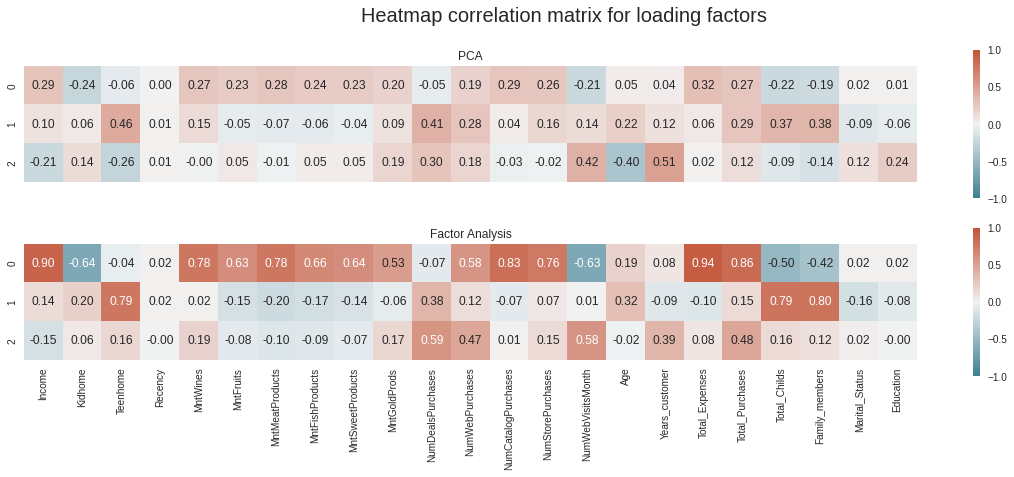

<Figure size 576x396 with 0 Axes>

In [89]:
### plot the heatmap for correlation matrix of 
# plot in maplotlib
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, 
                               sharey=True,figsize = (20, 6))

# PCA
sns.heatmap(loadings.T, vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(220, 20, n=200),
            square=True, annot=True, fmt='.2f', 
            ax =ax1).set(title='PCA')

# FA
sns.heatmap(fa_loading.T, vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(220, 20, n=200),
            square=True, annot=True, fmt='.2f', 
            ax = ax2).set(title='Factor Analysis')

# set up lapout
plt.tick_params(axis = 'x', labelsize=10, rotation=90)
fig.suptitle('Heatmap correlation matrix for loading factors', fontsize = 20)
plt.show() 

plt.savefig('6.Correlation_matrix_of_loading_factors.png')



As we can see, for both method, we would choose to analyze 3 components/factors. PCA method give us higher cumulative variance compared to FA, which are nearly 57% and 54% respectively. However, from the heatmap above, we can see some patterns of loadings explaining for PCA method at each components, but they are not too obvious. This is because the goal of PCA is to extract maximum variance from a dataset with a few orthogonal components, in order to provide only an empirical summary of the dataset. For the Factor Analysis, the loadings can provide a clearer underlying patterns for each factor.

Therefore, we would proceed Factor analysis for further analysis.

As a rule of thumb, The greater the loading, the more the variable is a pure measure of the factor. Moreover, Comrey and Lee (1992) suggest that loadings of >55% (30% overlapping variance) indicates good. Therefore, we would choose 55% as our threshold to look detail at loading factors in factor analysis.

In [56]:
thres = 0.55
g1 = fa_loading.loc[(fa_loading[0])>thres]
g2 = fa_loading.loc[(fa_loading[1])>thres]
g3 = fa_loading.loc[(fa_loading[2])>thres]

print("----- Group 1")
print(g1)
print("----- Group 2")
print(g2)
print("----- Group 3")
print(g3)

----- Group 1
                            0         1         2
Income               0.896811  0.139134 -0.151965
MntWines             0.777204  0.018484  0.192440
MntFruits            0.634103 -0.154814 -0.077946
MntMeatProducts      0.781790 -0.200618 -0.104798
MntFishProducts      0.660545 -0.174669 -0.088253
MntSweetProducts     0.637884 -0.139088 -0.065647
NumWebPurchases      0.579395  0.118881  0.471531
NumCatalogPurchases  0.825694 -0.072623  0.013055
NumStorePurchases    0.763643  0.067277  0.151522
Total_Expenses       0.944542 -0.103642  0.075149
Total_Purchases      0.855125  0.154973  0.483737
----- Group 2
                       0         1         2
Teenhome       -0.039747  0.788063  0.160651
Total_Childs   -0.500954  0.790957  0.156017
Family_members -0.417586  0.802984  0.117127
----- Group 3
                          0         1         2
NumDealsPurchases -0.071540  0.381739  0.590685
NumWebVisitsMonth -0.628078  0.005548  0.579351


Group 1: Real purchase - insensible to price

Group 2: Kids and number of family members affect a lot

Group 3: Window shopping - not really purchase

### 2.2.3. Clustering

In [57]:
components_sparse = fa_new.fit_transform(df_scaled)
# save factor score
df_sparse = pd.DataFrame(components_sparse, columns= ('comp_1','comp_2', 'comp_3'))
df_sparse.head()

,comp_1,comp_2,comp_3
0,1.037997,-1.642993,0.778798
1,-0.815323,1.250182,-0.853093
2,0.755383,-0.769853,-0.165051
3,-1.092160,-0.520453,-0.309654
4,0.017361,-0.041242,0.098747


#### Hierarchical clustering

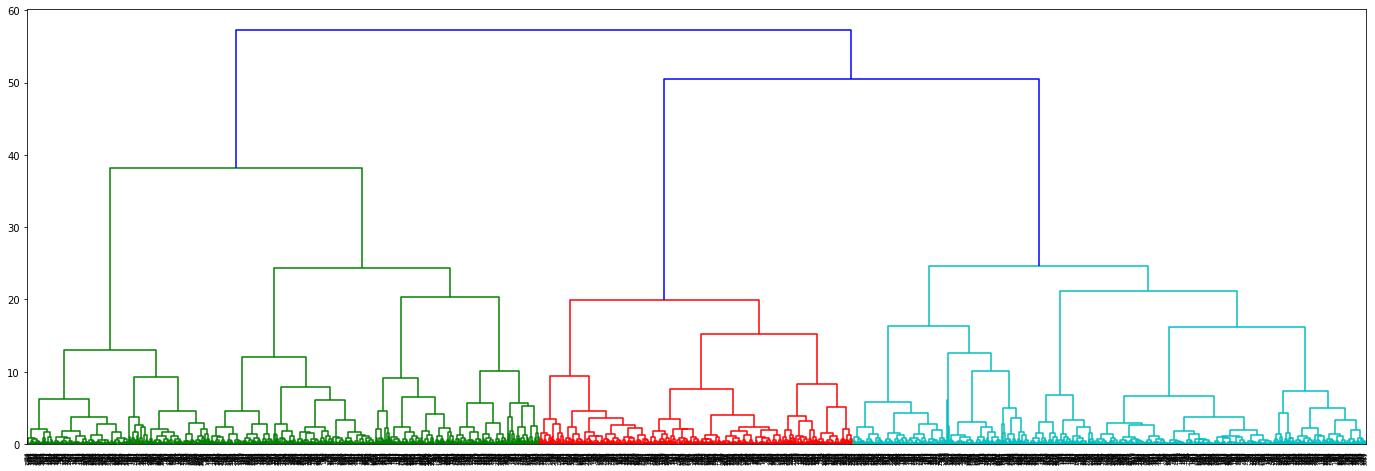

In [58]:
W = linkage(df_sparse,method='ward')
fig = plt.figure(figsize=(24,8))
ax = fig.add_subplot(111)
dendrogram(W,ax=ax)
plt.show()

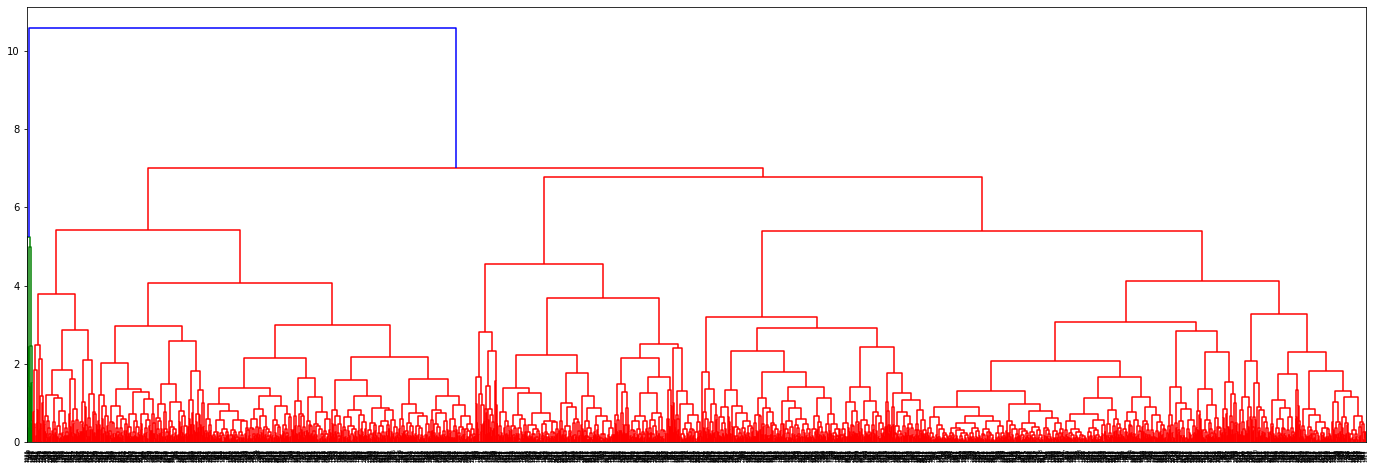

In [59]:
Y = linkage(df_sparse,method='complete')
fig = plt.figure(figsize=(24,8))
ax = fig.add_subplot(111)
dendrogram(Y,ax=ax)
plt.show()

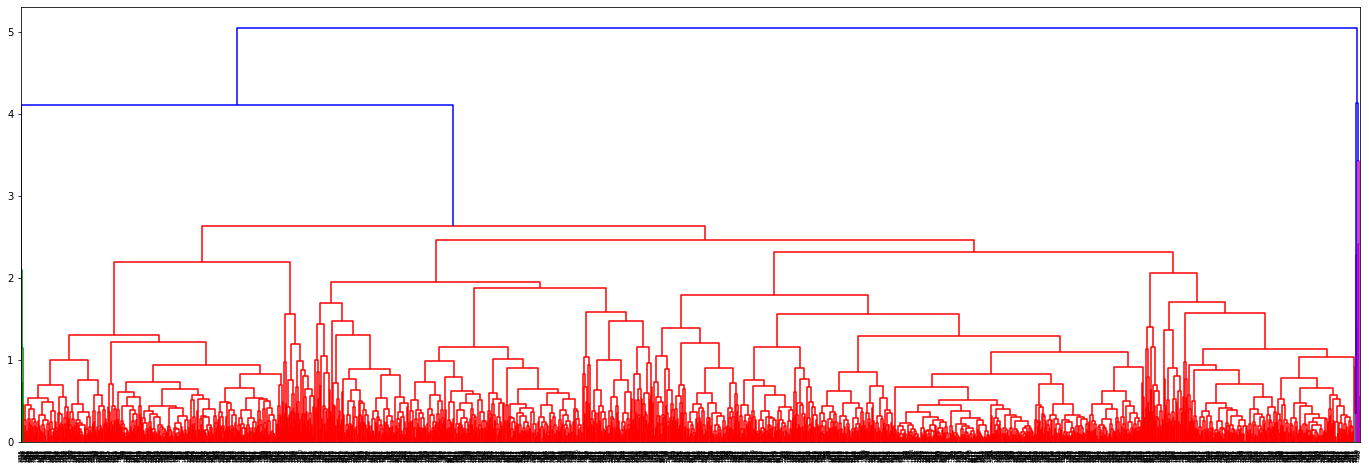

In [60]:
Z = linkage(df_sparse,method='average')
fig = plt.figure(figsize=(24,8))
ax = fig.add_subplot(111)
dendrogram(Z,ax=ax)
plt.show()

It seems like `ward` method is more esier to interpret. Let's use `ward` method with normalization

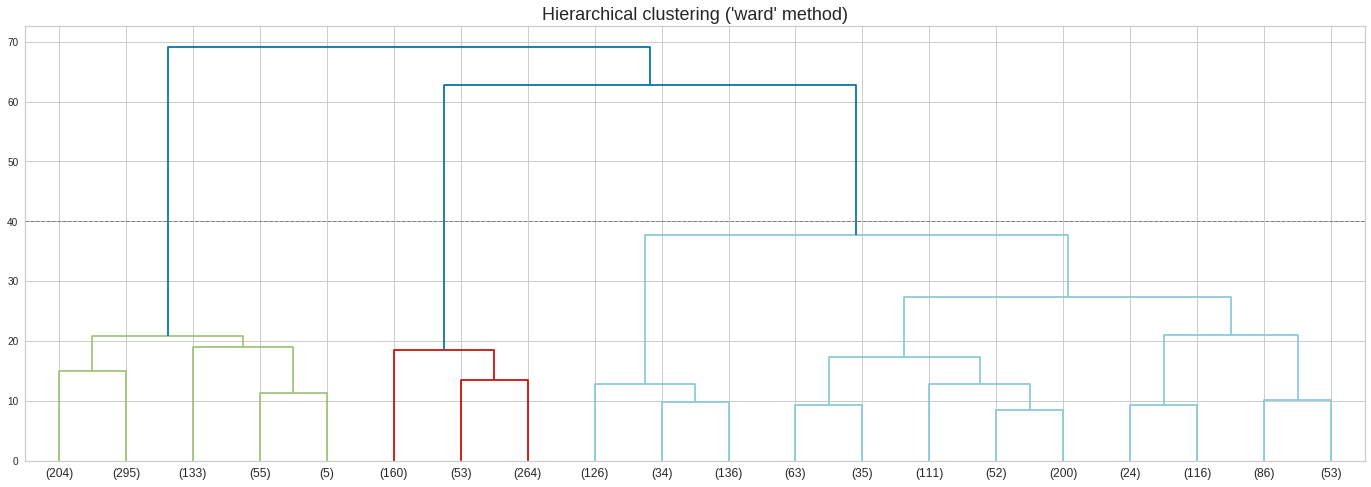

<Figure size 576x396 with 0 Axes>

In [91]:
# scaled df_sparse for better visualized
min_max_scaler = preprocessing.MinMaxScaler()
pca_norm = df_sparse.copy()
pca_norm[['z1','z2','z3']] = min_max_scaler.fit_transform(pca_norm[['comp_1',	'comp_2',	'comp_3']])
pca_norm.head()

# plot hierarchical clustering
W = linkage(pca_norm,method='ward')
fig = plt.figure(figsize=(24,8))
ax = fig.add_subplot(111)
dendrogram(W,ax=ax, truncate_mode = 'lastp', p=20)
plt.axhline(y=40, c='grey', lw=1, linestyle='dashed')
plt.title("Hierarchical clustering ('ward' method)",fontsize=18)
plt.show()

plt.savefig('7.Hierarchical clustering based on ‘ward’ method.png')

In the business perspective, the company cannot afford to personalized the as more specific the group as possible, but we want to target our clients as precise as we could. Thus, based on the intertia plot and previous "ward" hierarchical plot, we choose three clusters. 

#### K-Means clustering

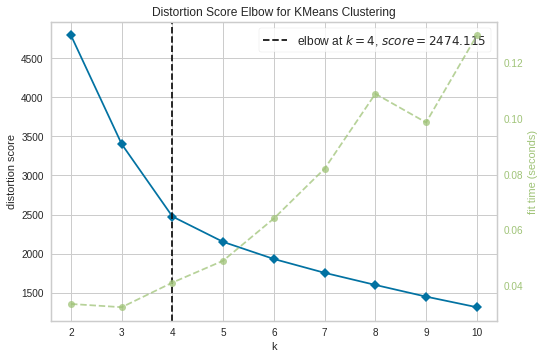

In [62]:
## choosing number of clusters from KElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(df_sparse)
Elbow_M.show()

In [63]:
## manually choosing kmeans
inertia_K=[]
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, init='k-means++',
    n_init=10,
    max_iter=300,
    tol=0.0001,
    verbose=0,
    random_state=56,
    copy_x=True,
    algorithm='auto')
    kmeanModel.fit(df_sparse)
    inertia_K.append(kmeanModel.inertia_)

In [92]:
df_plot3 = pd.DataFrame({'Number of clusters':K,
                        'inertia_K':inertia_K})
fig3 = go.Figure(data=go.Scatter(y=df_plot3['inertia_K'] , x= df_plot3['Number of clusters']))
fig3.update_layout(title='K-means clustering with Factor Analysis ',
                   xaxis_title='Number of clusters',
                   yaxis_title='Inertia_K')

fig3.show()

fig3.write_html("8.K-means clustering with Factor Analysis.html")

Base on 2 plots above, it looks like number of clusters varies from 3 to 5. Let's compared snake plot of each clusters

In [65]:
# data to plot
#### 3 clusters
kmeans3 = KMeans(n_clusters=3, init='k-means++', n_init=10, #how many time the algoritm runs
    max_iter=300, tol=0.0001, verbose=0, random_state=56,
    copy_x=True, algorithm='auto').fit(df_sparse)
df_3cluster = df_scaled.copy()
df_3cluster["Labels"]= kmeans3.labels_
df_3cluster_melt = pd.melt(df_3cluster.reset_index(), id_vars=['Labels'],
                  value_vars= df_3cluster.columns, var_name='Attribute',
                  value_name='Value')
#### 4 clusters
kmeans4 = KMeans(n_clusters=4, init='k-means++', n_init=10, #how many time the algoritm runs
    max_iter=300, tol=0.0001, verbose=0, random_state=56,
    copy_x=True, algorithm='auto').fit(df_sparse)
df_4cluster = df_scaled.copy()
df_4cluster["Labels"]= kmeans4.labels_
df_4cluster_melt = pd.melt(df_4cluster.reset_index(), id_vars=['Labels'],
                  value_vars= df_4cluster.columns, var_name='Attribute',
                  value_name='Value')
#### 5 clusters
kmeans5 = KMeans(n_clusters=5, init='k-means++', n_init=10, #how many time the algoritm runs
    max_iter=300, tol=0.0001, verbose=0, random_state=56,
    copy_x=True, algorithm='auto').fit(df_sparse)
df_5cluster = df_scaled.copy()
df_5cluster["Labels"]= kmeans5.labels_
df_5cluster_melt = pd.melt(df_5cluster.reset_index(), id_vars=['Labels'],
                  value_vars= df_5cluster.columns, var_name='Attribute',
                  value_name='Value')

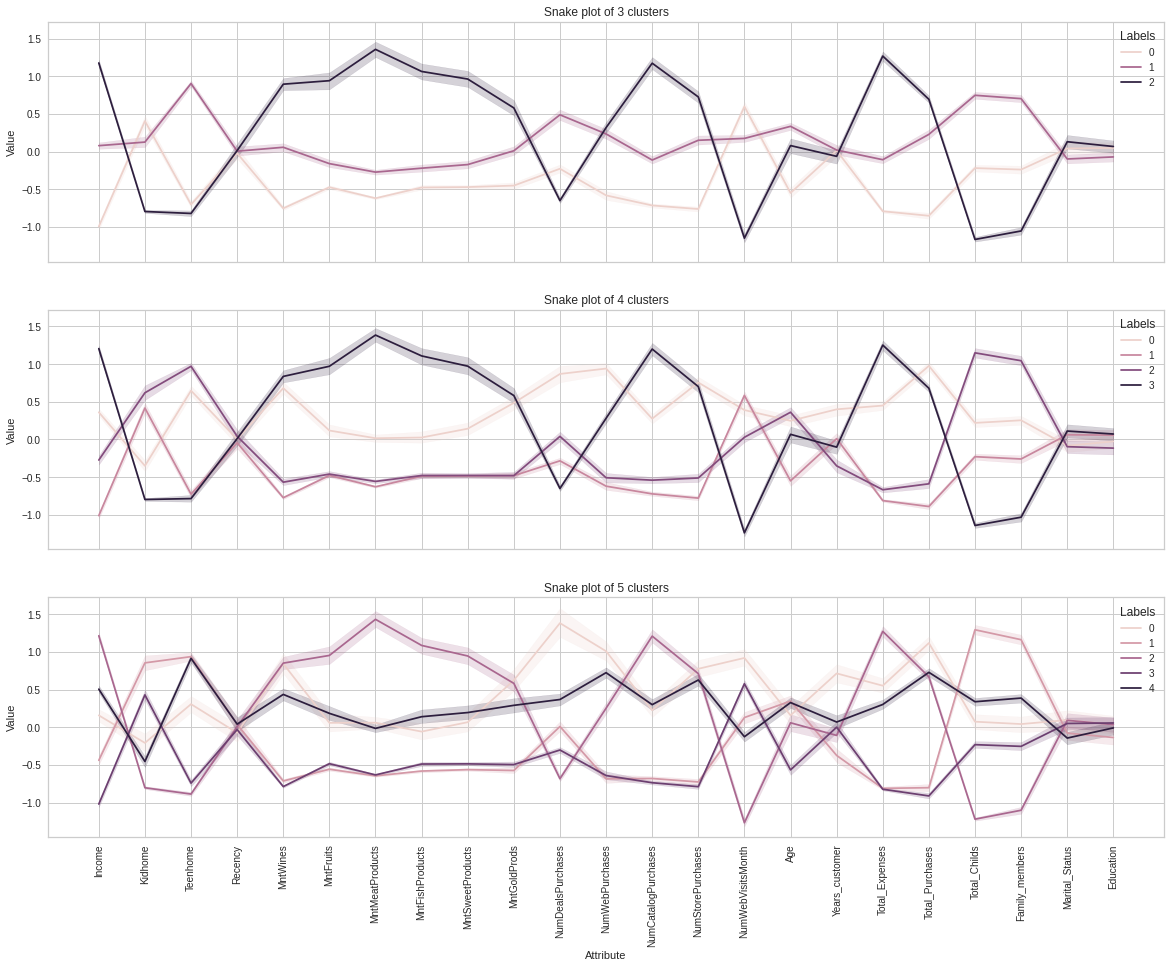

In [93]:
# plot in maplotlib
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, sharey=True,figsize = (20, 15))
sns.lineplot(x="Attribute", y="Value", hue='Labels', data=df_3cluster_melt, 
             ax = ax1).set(title='Snake plot of 3 clusters')
sns.lineplot(x="Attribute", y="Value", hue='Labels', data=df_4cluster_melt, 
             ax = ax2).set(title='Snake plot of 4 clusters')
sns.lineplot(x="Attribute", y="Value", hue='Labels', data=df_5cluster_melt, 
             ax = ax3).set(title='Snake plot of 5 clusters')
plt.tick_params(axis = 'x', labelsize=10, rotation=90)
plt.show() 

#fig.savefig('9.Snakeplot_of_clusters.png')

As we can see from the plot above, 3 clusters look like the best option and we saw a similar number of clusters in Hierarchical Clustering methods. 

In the plot with 4 and 5 clusters, we can see some overlapping clusters, which is not good for us in the exploratory process. It will be hard for company to segment customers in this case. Also, from business point of view, it would be expensive to run more than 3 marketing campaign. If we use 2 clusters we see some risks, which cannot cover details of customers. Even though the clusters do not overlap, they are too different and we do not target people between them. 

So we would use 3 cluster.

In [67]:
kmeans = KMeans(n_clusters=3, init='k-means++',
    n_init=10, #how many time the algoritm runs
    max_iter=300,
    tol=0.0001,
    verbose=0,
    random_state=56,
    copy_x=True,
    algorithm='auto').fit(df_sparse)

In [68]:
kmeans.labels_

array([2, 1, 2, ..., 2, 1, 1], dtype=int32)

In [69]:
kmeans.cluster_centers_

array([[-0.89430409, -0.82319851,  0.00133104],
       [-0.01766278,  0.9144795 ,  0.29316041],
       [ 1.2357409 , -0.67691418, -0.57726761]])

In [70]:
labels2 = kmeans.labels_
L = pd.DataFrame(labels2)
L.value_counts()

1    1001
0     690
2     514
dtype: int64

In [71]:
print ("The largest cluster is ", round(max(L.value_counts())/sum(L.value_counts())*100,2 ), '%')
print ('The second largest cluster is ', round((sum(L.value_counts()) - max(L.value_counts()) - min(L.value_counts()) )/sum(L.value_counts())*100,2), '%')
print ('The smallest cluster is ', round(min(L.value_counts())/sum(L.value_counts())*100,2), '%')

The largest cluster is  45.4 %
The second largest cluster is  31.29 %
The smallest cluster is  23.31 %


By using both PCA and clustering method, we can conclude that we would choose 3 components and 3 clustering to segment our customer in business context

In [94]:
# Add labels to df_sparse 
df_sparse['Cluster_Id'] = labels2.astype(str)

# Plot in 3D plot
fig5 = px.scatter_3d(
    df_sparse, x=df_sparse['comp_1'], y=df_sparse['comp_2'], z=df_sparse['comp_3'], 
    color=df_sparse['Cluster_Id'],
    title='The Plot Of The Clusters',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig5.show()

fig5.write_html("9.Clusters_plot.html")

# 3. Profile profilling

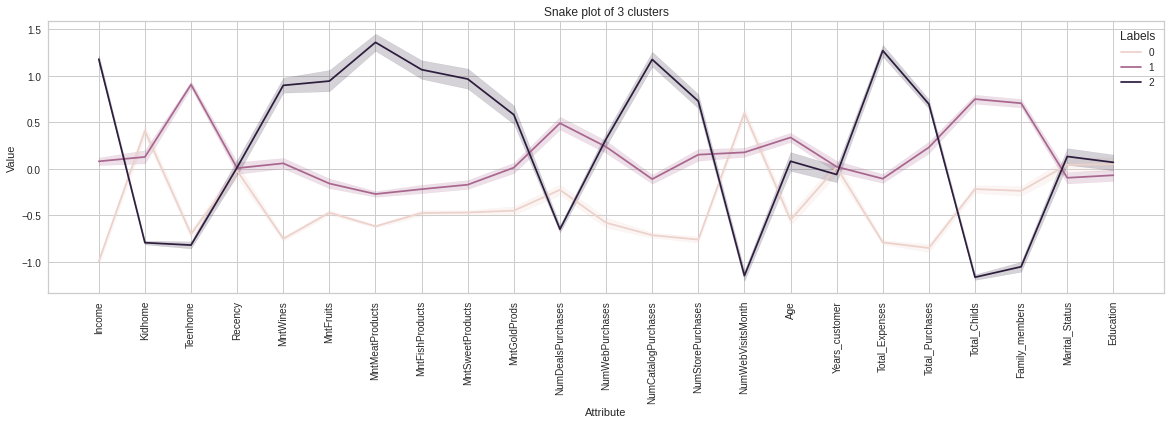

<Figure size 576x396 with 0 Axes>

In [95]:
fig = plt.figure(figsize = (20, 5))

ax1 = fig.add_subplot(111)

sns.lineplot(x="Attribute", y="Value", hue='Labels', data=df_3cluster_melt, 
             ax = ax1).set(title='Snake plot of 3 clusters')
plt.tick_params(axis = 'x', labelsize=10, rotation=90)
plt.show() 

plt.savefig('10.Snakeplot_of_3_clusters.png')

In [74]:
df_info = df.copy()
df_info["Labels"]= kmeans.labels_.astype(str)
df_info

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,NumWebVisitsMonth,Age,Years_customer,Total_Expenses,Total_Purchases,Total_Childs,Family_members,Marital_Status,Education,Labels
0,58138.0,0,0,58,635,88,546,172,88,88,...,7,65,10,1617,25,0,1,Single,Undergraduate,2
1,46344.0,1,1,38,11,1,6,2,1,6,...,5,68,8,27,6,2,3,Single,Undergraduate,1
2,71613.0,0,0,26,426,49,127,111,21,42,...,4,57,9,776,21,0,2,Couples,Undergraduate,2
3,26646.0,1,0,26,11,4,20,10,3,5,...,6,38,8,53,8,1,3,Couples,Undergraduate,0
4,58293.0,1,0,94,173,43,118,46,27,15,...,5,41,8,422,19,1,3,Couples,Higher education,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2203,61223.0,0,1,46,709,43,182,42,118,247,...,5,55,9,1341,18,1,3,Couples,Undergraduate,1
2204,64014.0,2,1,56,406,0,30,0,0,8,...,7,76,8,444,22,3,5,Couples,Higher education,1
2205,56981.0,0,0,91,908,48,217,32,12,24,...,6,41,8,1241,19,0,2,Single,Undergraduate,2
2206,69245.0,0,1,8,428,30,214,80,30,61,...,3,66,8,843,23,1,3,Couples,Higher education,1


In [75]:
# labels distribution
df_labels = df_info[['Labels']].groupby(['Labels']).size().reset_index(name='counts')
fig_label_distibution = px.pie(df_labels, values='counts', names='Labels', 
                               color_discrete_sequence=px.colors.sequential.RdBu,
                              title ='Distibution of customers in each clusters')
fig_label_distibution.update_layout(legend_title="Clusters")
fig_label_distibution.show()

## 3.1. Customer information

In [76]:
# set colout for each cluster 
color_dict = {'0': '#636EFA', '1':'#EF553B', '2': '#00CC96'}
label = ['0','1','2']

In [97]:
# Income vs Total purchase distribution
df_plot_6 = df_info[['Income','Total_Expenses','Labels']] 
fig6 = px.scatter(df_plot_6, x='Income', y='Total_Expenses',
                  marginal_x='histogram', marginal_y='histogram',
                  color='Labels', color_discrete_map=color_dict,
                  category_orders={"Labels": ["0", "1", "2"]},
                  title ='Total expense vs Income between each clusters')
fig6.update_layout(legend_title="Clusters")
fig6.show()

fig6.write_html("12.Expense_Income_each_clsuters.html")

In [96]:
### Initialize figure with subplots
fig8_1 = make_subplots(
    rows=1, cols=2,
    column_widths=[0.6, 0.4],
    #row_heights=[0.5, 0.5],
    specs=[[{"type": "sunburst"}, {"type": "bar"}]],
    subplot_titles=("Total children", "Number of Kid and Teen"))

### 1.Sunburst plot total of kids
# prepare data to plot
df_plot_kid = df_info[['Labels','Total_Childs']].groupby(['Labels','Total_Childs']).size().reset_index(name='counts')
# rename for visualization
df_plot_kid.loc[df_plot_kid['Total_Childs'] ==0, 'Total_Childs_name'] = 'No kid'
df_plot_kid.loc[df_plot_kid['Total_Childs'] ==1, 'Total_Childs_name'] = '1 child'
df_plot_kid.loc[df_plot_kid['Total_Childs'] ==2, 'Total_Childs_name'] = '2 children'
df_plot_kid.loc[df_plot_kid['Total_Childs'] ==3, 'Total_Childs_name'] = '3 children'
# plot sunburst
fig8 = px.sunburst(df_plot_kid, path=['Labels', 'Total_Childs_name',], values='counts')
# Add sunburst chart of total kid
fig8_1.add_trace(
    go.Sunburst(
        ids=fig8['data'][0]['ids'].tolist() ,
        labels=fig8['data'][0]['labels'].tolist(),
        parents=fig8['data'][0]['parents'].tolist(),
        values=fig8['data'][0]['values'].tolist()
        ),
    row=1, col=1, 
)

### 2. Bar chart of teen home
# prepare data to plot
y_teen = df_info[['Labels','Teenhome']].groupby(['Labels']).sum().reset_index()['Teenhome'].to_list()
y_kid = df_info[['Labels','Kidhome']].groupby(['Labels']).sum().reset_index()['Kidhome'].to_list()
# plotly figure
fig8_1.add_trace(go.Bar(name = 'Teenhome', x= ['0','1','2'], y = y_teen, marker_color = '#AB63FA'), row=1, col=2)
fig8_1.add_trace(go.Bar(name = 'Kidhome', x= ['0','1','2'], y = y_kid,  marker_color = '#FFA15A'), row=1, col=2)
fig8_1.update_layout(barmode='stack', xaxis_title = "Cluster", yaxis_title = "Counts")

# plot
fig8_1.update_layout(title_text="Number of child at each clusters",
                     legend_title="Children")
fig8_1.show()

fig8_1.write_html("11.Children_each_clusters.html")

In [79]:
### Initialize figure with subplots
fig9 = make_subplots(
    rows=2, cols=2,
    column_widths=[0.5, 0.5],
    row_heights=[0.5, 0.5],
    specs=[[{"type": "box"}, {"type": "box"}],
           [{"type": "box"}, {"type": "box"}]],
    subplot_titles=("Age", "Recency", "Education","Marital Status"))

### 1.Age
# prepare data to plot
df_plot_age = df_info[['Labels','Age']]
# plotly figure
for t in label:
    dfp = df_plot_age[df_plot_age['Labels']==t]
    fig9.add_trace(go.Box(y = dfp['Age'], name=str(t),marker_color=color_dict[t]), 
                      row=1, col=1, 
    )
fig9.update(layout_showlegend=False)

### 2.Recency
# prepare data to plot
df_plot_rec = df_info[['Labels','Recency']]
# plotly figure
for t in label:
    dfp = df_plot_rec[df_plot_rec['Labels']==t]
    fig9.add_trace(go.Box(y = dfp['Recency'], name=str(t),marker_color=color_dict[t]), 
                      row=1, col=2, 
    )

### 3. Education
# prepare data to plot
df_plot_edu = df_info[['Labels','Education']].groupby(['Labels','Education']).size().reset_index(name='counts')
# plotly figure
for t1 in label:
    dfp1 = df_plot_edu[df_plot_edu['Labels']==t1]
    fig9.add_trace(go.Bar(x=dfp1['Education'], y = dfp1['counts'], name=str(t1),marker_color=color_dict[t1]),
                   row=2, col=1)
    
### 4. Marital_Status
# prepare data to plot
df_plot_ma = df_info[['Labels','Marital_Status']].groupby(['Labels','Marital_Status']).size().reset_index(name='counts')
# plotly figure
for t1 in label:
    dfp1 = df_plot_ma[df_plot_ma['Labels']==t1]
    fig9.add_trace(go.Bar(x=dfp1['Marital_Status'], y = dfp1['counts'], name=str(t1),marker_color=color_dict[t1]),
                   row=2, col=2)


# show
fig9.show()

## 3.2. Purchasing behaviour

In [80]:
df_exp_plot = df_info[['Total_Purchases','Labels']]
fig7 = px.histogram(df_exp_plot, x="Total_Purchases", nbins=50,
                   color="Labels", color_discrete_map=color_dict,
                   marginal="box", 
                   hover_data=df_exp_plot.columns,
                   category_orders={"Labels": ["0", "1", "2"]},
                   title = "Distribution of Total purchase")
fig7.update_layout(legend_title="Clusters")
fig7.show()  
#fig7.write_html("5.3.Total_purchase_each_clusters.html")

In [99]:
# data preparation
df_buy = df_info[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 
                  'MntSweetProducts', 'MntGoldProds', 'Labels']]
df_buy.rename(columns={'MntWines': 'Wines', 'MntFruits': 'Fruits',
                      'MntMeatProducts': 'Meat', 'MntFishProducts': 'Fish',
                       'MntSweetProducts': 'Sweet', 'MntGoldProds': 'Gold',
                       }, inplace=True)
y_0_df = df_buy.loc[df_buy['Labels']=='0'].drop(['Labels'], axis = 1).melt()
y_1_df = df_buy.loc[df_buy['Labels']=='1'].drop(['Labels'], axis = 1).melt()
y_2_df = df_buy.loc[df_buy['Labels']=='2'].drop(['Labels'], axis = 1).melt()
y_3_df = df_buy.loc[df_buy['Labels']=='3'].drop(['Labels'], axis = 1).melt()

# plot  
fig10 = go.Figure()
fig10.add_trace(go.Box( y=y_0_df['value'], x=y_0_df['variable'], 
                       name='0', marker_color=color_dict['0']))
fig10.add_trace(go.Box( y=y_1_df['value'], x=y_1_df['variable'], 
                       name='1', marker_color=color_dict['1']))
fig10.add_trace(go.Box( y=y_2_df['value'], x=y_2_df['variable'], 
                       name='2', marker_color=color_dict['2']))
fig10.add_trace(go.Box( y=y_3_df['value'], x=y_3_df['variable'], 
                       name='3' ) )#, marker_color=color_dict['3']))

# set up layout
fig10.update_layout(title_text="Amount spend on differents products in last 2 years",
                     legend_title="Clusters",
                     yaxis_title='Counts', xaxis_title='Products', 
                     boxmode='group' )

fig10.show()

fig10.write_html("14.Amt_prd_each_clusters.html")

Meat and wines are bought more, compared to others products

cluster 1 and 2, spending more (high income)

In [100]:
# data preparation
df_pc = df_info[['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 
                 'NumStorePurchases', 'Labels']]
df_pc.rename(columns={'NumDealsPurchases': 'Deals', 'NumWebPurchases': 'Web',
                      'NumCatalogPurchases': 'Catalog', 'NumStorePurchases': 'Store'}, inplace=True)
y_0_pc = df_pc.loc[df_pc['Labels']=='0'].drop(['Labels'], axis = 1).melt()
y_1_pc = df_pc.loc[df_pc['Labels']=='1'].drop(['Labels'], axis = 1).melt()
y_2_pc = df_pc.loc[df_pc['Labels']=='2'].drop(['Labels'], axis = 1).melt()

# plot  
fig11 = go.Figure()
fig11.add_trace(go.Box( y=y_0_pc['value'], x=y_0_pc['variable'], 
                       name='0', marker_color=color_dict['0']))
fig11.add_trace(go.Box( y=y_1_pc['value'], x=y_1_pc['variable'], 
                       name='1', marker_color=color_dict['1']))
fig11.add_trace(go.Box( y=y_2_pc['value'], x=y_2_pc['variable'], 
                       name='2', marker_color=color_dict['2']))

# set up layout
fig11.update_layout(title_text="Number of purchase through different channel",
                     legend_title="Clusters",
                     yaxis_title='Counts', xaxis_title='Type purchase', 
                     boxmode='group' )

fig11.show()

fig11.write_html("15.Purchase_each_clusters.html")

In [98]:
# data preparation
df_web = df_info[['NumWebVisitsMonth','Labels']]
y0_web = df_web.loc[df_web['Labels']=='0'].drop(['Labels'], axis = 1).melt()
y1_web = df_web.loc[df_web['Labels']=='1'].drop(['Labels'], axis = 1).melt()
y2_web = df_web.loc[df_web['Labels']=='2'].drop(['Labels'], axis = 1).melt()
# plotly
fig_web = go.Figure()
fig_web.add_trace(go.Box( y=y0_web['value'], 
                       name='0', marker_color=color_dict['0']))
fig_web.add_trace(go.Box( y=y1_web['value'], 
                       name='1', marker_color=color_dict['1']))
fig_web.add_trace(go.Box( y=y2_web['value'], 
                       name='2', marker_color=color_dict['2']))

# set up layout
fig_web.update_layout(title_text="Number of Web visits Month",
                     showlegend = False, 
                     yaxis_title='Counts', xaxis_title='Clusters')

fig_web.show()

fig_web.write_html("13.Web_vst_each_clusters.html")

# 4. Inisghts from customer personal analysis 

1. **Cluster 0 (1st segment)**
*   Low income
*   Have 1 child, mostly kid
*   Regularly visit web 
*   Average age around 43 years old
*   Mostly purchase at physical channels 
*   Lowest amount of spending


2.   **Cluster 1 (2nd segment)**

*   Middle income
*   Have lots of children, mostly teenagers
*   Sometimes visit website
*   Average age around 53 years old
*   Mostly are couples
*   Mostly purchase at physical channels, and sometimes are web
*   Loves deals purchases
*   Fan of wines, and some time spend money for meat


3.   **Cluster 2 (3nd segment)**

*   High income
*   Do not have kid
*   Rarely visit website
*   Average age around 57 years old
*   Highest amount of expense and number of purchase
*   Normally purchase at stores, frequently via web and catalogue, but hardly ever buy deals.
*   Wine and meat lovers; fish might be an alternative meal for meat; and occasionally bought sweet, fruits and gold.



